In [1]:
## Load Libraries

import pandas as pd
import numpy as np
import os
import re
import pytz
import yfinance as yf
from dotenv import load_dotenv
import openai
from sklearn.cluster import KMeans
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

pd.set_option("display.max_columns", 50)

In [2]:
## Load Company Data

corps = pd.read_csv("data/corps.csv")

industrials = pd.read_csv("data/corps/industrials.csv")
healthcare = pd.read_csv("data/corps/healthcare.csv")
finance = pd.read_csv("data/corps/finance.csv")
tech = pd.read_csv("data/corps/tech.csv")
consumer = pd.read_csv("data/corps/consumer.csv")
energy = pd.read_csv("data/corps/energy.csv")

In [75]:
## Load Cleaned Data

prices = pd.read_csv("data/industrials_073124/prices.csv", index_col=0)
news = pd.read_csv("data/industrials_073124/news.csv", index_col=0)

### **News Features**

In [4]:
freq = news.groupby("Ticker")["Ticker"].size().sort_values(ascending=False).reset_index(name="Count")

freq[freq["Count"]>100]

,Ticker,Count
0,BA,1155
1,EML,886
2,GORO,737
3,TISI,703
4,RS,685
...,...,...
78,HA,110
79,JCI,109
80,STCN,107
81,CBT,106


In [27]:
fast = news[news["Ticker"]=="FAST"].copy()
fast.head()

,Time,Ticker,Name,Heading,Subheading,Publisher,Found,Recency
1097,2024-06-20 15:30:00,FAST,Fastenal,"Laser Photonics Inks Deals With Brokk, Fastena...",and its laser-based solutions are changing the...,benzinga.com,2024-06-20 15:04:52,0 days 02:31:58
2253,2024-06-21 12:30:00,FAST,Fastenal,Fastenal's (FAST) Average Daily Sales Increase...,Fastenal Company FAST recently released its Ma...,sg.news.yahoo.com,2024-06-21 12:04:49,0 days 10:47:54
3758,2024-06-24 09:30:00,FAST,Fastenal,Fastenal Co. stock underperforms Friday when c...,Shares of Fastenal Co. inched 0.34% higher to ...,marketwatch.com,2024-06-22 13:04:47,0 days 16:07:43
4539,2024-06-24 09:30:00,FAST,Fastenal,Wedmont Private Capital Purchases 224 Shares o...,"Czech National Bank now owns 100,685 shares of...",defenseworld.net,2024-06-23 13:04:40,0 days 05:45:41
4540,2024-06-24 09:30:00,FAST,Fastenal,Fastenal (FAST) Gains But Lags Market: What Yo...,The PEG ratio is similar to the widely-used P/...,nz.news.yahoo.com,2024-06-23 13:04:40,0 days 11:19:32


In [43]:
## Publisher Frequency

freq = news.groupby("Publisher")["Publisher"].size() \
    .reset_index(name="Count").sort_values("Count", ascending=False)

In [60]:
## Publisher Effect

pnews = pd.merge(news, prices[["Time", "Ticker", "Delta+1"]], how="left", on=["Time", "Ticker"])
pnews_pos = pnews[pnews["Delta+1"]>0]
pnews_neg = pnews[pnews["Delta+1"]<0]
pnews["Abs_Delta+1"] = pnews["Delta+1"].abs()
effect = pnews.groupby("Publisher")["Abs_Delta+1"].mean() \
    .reset_index(name="Effect").sort_values("Effect", ascending=False)
effect_pos = pnews_pos.groupby("Publisher")["Delta+1"].mean() \
    .reset_index(name="Effect").sort_values("Effect", ascending=False)
effect_neg = pnews_neg.groupby("Publisher")["Delta+1"].mean() \
    .reset_index(name="Effect").sort_values("Effect", ascending=True)

In [67]:
top_neg_pubs = pd.merge(freq[freq["Count"]>50], effect_neg, how="left", on="Publisher") \
    .sort_values("Effect", ascending=True).head(50)["Publisher"].values.tolist()

top_pos_pubs = pd.merge(freq[freq["Count"]>50], effect_pos, how="left", on="Publisher") \
    .sort_values("Effect", ascending=False).head(50)["Publisher"].values.tolist()

In [76]:
news["TNP"] = np.where(news["Publisher"].isin(top_neg_pubs), 1, 0)
news["TPP"] = np.where(news["Publisher"].isin(top_pos_pubs), 1, 0)

### **Clustering**

In [6]:
## Create Embeddings

headings_list = news[news["Ticker"]=="FAST"]["Heading"].values.tolist()

load_dotenv()
api_key = os.getenv('OPENAI_API_KEY')

oai = openai.OpenAI(
    api_key=api_key,
)

def get_embedding(text_to_embed, openai):
    response = openai.embeddings.create(
        model= "text-embedding-3-small",
        input=[text_to_embed]
    )
    return response.data[0].embedding

embeddings = []
for heading in headings_list:
    embeddings.append(get_embedding(heading, oai))

In [8]:
len(embeddings[0])

1536

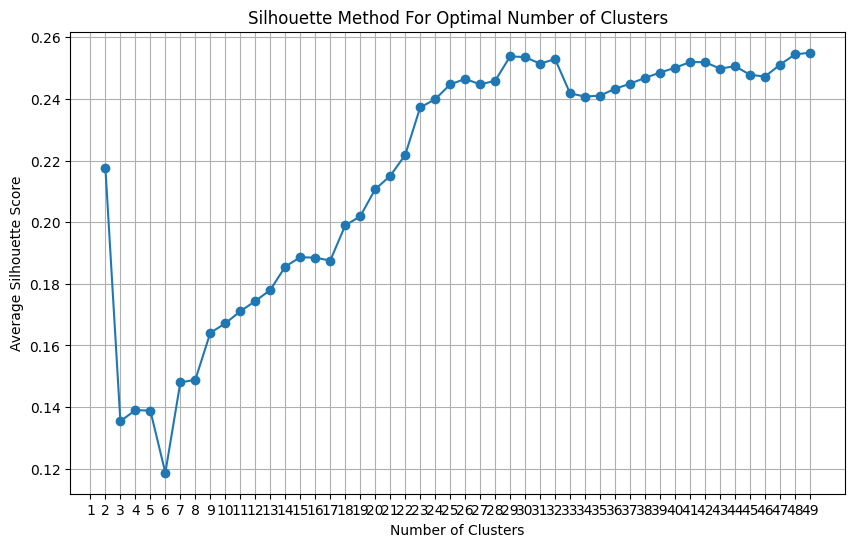

In [9]:
## Plot Silhouette Scores

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    n = 50

    range_n_clusters = range(2, n)
    silhouette_avg = []

    for n_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(embeddings)
        silhouette_avg.append(silhouette_score(embeddings, cluster_labels))

    plt.figure(figsize=(10, 6))
    plt.plot(range_n_clusters, silhouette_avg, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Average Silhouette Score')
    plt.title('Silhouette Method For Optimal Number of Clusters')
    plt.xticks(range(1, n))
    plt.grid(True)
    plt.show()

In [11]:
## Subject Names: Set Cluster Number and Create Mapping

optimal_n_clusters = 32

kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=1)
kmeans.fit(embeddings)
labels = kmeans.labels_

dict_labels = {heading: label for heading, label in zip(headings_list, labels)}

In [12]:
fast["Heading_Cluster"] = fast["Heading"].map(dict_labels)

### **Create Modeling Table**

In [87]:
## Create Modeling Table

news_df = news

news1 = news_df.groupby(["Time", "Ticker"]).agg({
    "Heading": list,
    "Subheading": list,
    "Publisher": list,
    "TNP": list,
    "TPP": list,
    "Found": list,
    "Recency": list
}).reset_index()

modeling = pd.merge(prices, news1,
         on=["Time", "Ticker"],
         how="left").fillna("")

modeling["Headlines_Cnt"] = modeling["Heading"].apply(len)
modeling["TNP_Cnt"] = modeling["TNP"].apply(sum)
modeling["TPP_Cnt"] = modeling["TPP"].apply(sum)
modeling["ID"] = modeling["Ticker"] + "-" + [x.replace(" ", "-")[5:-3] for x in modeling["Time"].astype(str)]
modeling["Hour"] = [x[11:-3] for x in modeling["Time"].astype(str)]

modeling1 = modeling[["ID", "Time", "Delta+1", "Hour", "Company", "Sector", "Cap",
                        "Open-1", "High-1", "Low-1", "Delta-1", "Open_Diff", "Volume-1",
                        "Dividends-1", "Stock_Splits-1",
                        "Heading", "Subheading", "Publisher", "Found", "Recency",
                        "TNP", "TPP", "TNP_Cnt", "TPP_Cnt",
                        "Headlines_Cnt"]]

modeling1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125608 entries, 0 to 125607
Data columns (total 25 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ID              125608 non-null  object 
 1   Time            125608 non-null  object 
 2   Delta+1         125608 non-null  float64
 3   Hour            125608 non-null  object 
 4   Company         125608 non-null  object 
 5   Sector          125608 non-null  object 
 6   Cap             125608 non-null  float64
 7   Open-1          125608 non-null  float64
 8   High-1          125608 non-null  float64
 9   Low-1           125608 non-null  float64
 10  Delta-1         125608 non-null  float64
 11  Open_Diff       125608 non-null  float64
 12  Volume-1        125608 non-null  int64  
 13  Dividends-1     125608 non-null  float64
 14  Stock_Splits-1  125608 non-null  float64
 15  Heading         125608 non-null  object 
 16  Subheading      125608 non-null  object 
 17  Publisher 

In [89]:
modeling1

,ID,Time,Delta+1,Hour,Company,Sector,Cap,Open-1,High-1,Low-1,Delta-1,Open_Diff,Volume-1,Dividends-1,Stock_Splits-1,Heading,Subheading,Publisher,Found,Recency,TNP,TPP,TNP_Cnt,TPP_Cnt,Headlines_Cnt
0,LIN-06-03-09:30,2024-06-03 09:30:00,-0.555145,09:30,Linde,Basic Materials,206652.0,430.309998,1.319977,-0.062743,1.271177,-0.376333,480713,0.0,0.0,,,,,,,,0,0,0
1,LIN-06-03-10:30,2024-06-03 10:30:00,0.180962,10:30,Linde,Basic Materials,206652.0,434.140015,0.562024,-0.498689,-0.192339,-0.019615,267563,0.0,0.0,,,,,,,,0,0,0
2,LIN-06-03-11:30,2024-06-03 11:30:00,0.121587,11:30,Linde,Basic Materials,206652.0,433.220001,0.251603,-0.595537,-0.555145,0.049905,192816,0.0,0.0,,,,,,,,0,0,0
3,LIN-06-03-12:30,2024-06-03 12:30:00,0.041627,12:30,Linde,Basic Materials,206652.0,431.029999,0.336406,-0.225043,0.180962,-0.005788,441609,0.0,0.0,,,,,,,,0,0,0
4,LIN-06-03-13:30,2024-06-03 13:30:00,0.375592,13:30,Linde,Basic Materials,206652.0,431.785004,0.195700,-0.228126,0.121587,0.018509,100792,0.0,0.0,,,,,,,,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125603,SIF-07-31-09:30,2024-07-31 09:30:00,0.000000,09:30,SIFCO Industries,Industrials,20.0,3.422500,0.000000,-4.747989,-0.949592,1.769910,0,0.0,0.0,,,,,,,,0,0,0
125604,SIF-07-31-12:30,2024-07-31 12:30:00,0.000000,12:30,SIFCO Industries,Industrials,20.0,3.450000,0.000000,0.000000,0.000000,1.449274,0,0.0,0.0,,,,,,,,0,0,0
125605,SIF-07-31-13:30,2024-07-31 13:30:00,0.000000,13:30,SIFCO Industries,Industrials,20.0,3.500000,0.000000,-2.854286,0.000000,-1.428570,717,0.0,0.0,,,,,,,,0,0,0
125606,SIF-07-31-14:30,2024-07-31 14:30:00,-1.179947,14:30,SIFCO Industries,Industrials,20.0,3.450000,0.000000,0.000000,0.000000,0.289855,610,0.0,0.0,,,,,,,,0,0,0
